In [90]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
# load image filenames with corresponding targets
def load_dataset(path):
    data = load_files(path)
    imgs = np.array(data['filenames'])
    targets = np.array(data['target'])
    return imgs, targets

train_filenames, train_targets = load_dataset("./data/train")
test_filenames, test_targets = load_dataset("./data/test")

print("There are %d training images" % len(train_filenames))
print("There are %d test images" % len(test_filenames))

There are 28709 training images
There are 7178 test images


# Difine a function to get the position of 68 points representing the emotion

In [136]:
import dlib
import numpy as np
frontalface_detector = dlib.get_frontal_face_detector()
landmark_predictor=dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
def get_landmarks(image_url):
    image = cv2.imread(image_url)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = frontalface_detector(gray, 1)
    if len(faces):
        landmarks = [(p.x, p.y) for p in landmark_predictor(image, faces[0]).parts()]
        for landmark in landmarks:
            if landmark[0] >= 48 or landmark[1] >= 48:
                return None
    else:
        return None
    
    return landmarks

## Auto detect 68 points for each of the train and test image

In [134]:
single_landmark = get_landmarks(train_filenames[6])
image = cv2.imread(train_filenames[9])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(gray)

[[246 244 246 ...  41  55  47]
 [244 246 245 ...  24  42  49]
 [245 245 245 ...  18  31  50]
 ...
 [242 245 244 ... 245 245 242]
 [247 243 243 ... 245 243 242]
 [244 242 246 ... 243 243 244]]


In [160]:
input_pixels = []
input_targets_modified = []
for index, single_image in enumerate(train_filenames):
    single_landmark = get_landmarks(single_image)
    if single_landmark is not None:
        image = cv2.imread(single_image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        single_image_pixels = [gray[l[0]][l[1]] for l in single_landmark]
        input_targets_modified.append(train_targets[index])
        input_pixels.append(single_image_pixels)
input_pixels = np.array(input_pixels)
input_targets_modified = np.array(input_targets_modified)

In [161]:
test_pixels = []
test_targets_modified = []
for index, single_image in enumerate(test_filenames):
    single_landmark = get_landmarks(single_image)
    if single_landmark is not None:
        image = cv2.imread(single_image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        single_image_pixels = [gray[l[0]][l[1]] for l in single_landmark]
        test_targets_modified.append(test_targets[index])
        test_pixels.append(single_image_pixels)

test_pixels = np.array(test_pixels)
test_targets_modified = np.array(test_targets_modified)

In [166]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

accuracies = []
accuracies_by_hyper = []
hyperparams = range(150, 170)
for k in hyperparams:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(input_pixels, input_targets_modified)
    predictions = knn.predict(test_pixels)
    accuracy_score_k = accuracy_score(test_targets_modified, predictions)*100
    accuracies.append(accuracy_score_k)
    accuracies_by_hyper.append([k, accuracy_score_k])

In [167]:
sorted_result = sorted(accuracies_by_hyper, key=lambda tup: tup[1])
# Get lambda with highest accuracy
best_hyperparam = sorted_result[-1][0]
best_neg_log_prob = sorted_result[-1][1]
print('best K is %d' %best_hyperparam)

best K is 153


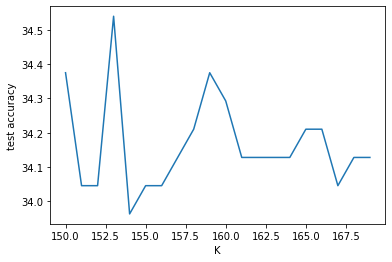

In [171]:
import matplotlib.pyplot as plt
plt.plot(hyperparams, accuracies)
plt.ylabel('test accuracy')
plt.xlabel('K')
plt.show()